In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib

In [6]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [40]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}
pass_HLT = {}
pass_L1 = {}
weights = {}

## Collect Data

In [41]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)

# Append to datasets
datasets['HLT_data'] = HLT_objects[:, :, [0, 2, 3]]
weights['HLT_data'] = EB_weights
pass_L1['HLT_data'] = pass_L1_idxs
pass_HLT['HLT_data'] = pass_HLT_idxs

datasets['L1_data'] = L1_objects
weights['L1_data'] = EB_weights
pass_L1['L1_data'] = pass_L1_idxs
pass_HLT['L1_data'] = pass_HLT_idxs

datasets['HLT_passedHLT'] = HLT_objects[pass_HLT_idxs][:, :, [0, 2, 3]]
weights['HLT_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['HLT_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['HLT_passedHLT'] = pass_HLT_idxs[pass_HLT_idxs]

datasets['L1_passedHLT'] = L1_objects[pass_HLT_idxs]
weights['L1_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['L1_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['L1_passedHLT'] = pass_HLT_idxs[pass_HLT_idxs]

In [42]:
# Read MC data. Remove E.

filenames = ['Ztautau',
             #'HHbbttHadHad.h5', 
             'ZZ4lep',  
             #'jjJZ4.h5', 
             #'jjJZ2.h5', 
             'qqa', 
             'HNL7p5_ctau1_eemu',
             'Zprime2EJs',
             'HAHMggfZdZd2l2nu']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename+'.h5', 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]
        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets['HLT_'+filename] = combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

In [43]:
# Read other MC data.

filenames = ['HHbbttHadHad',   
             'jjJZ4', 
             'jjJZ2'
            ]
data_path = '../../../../ntuples/L1_MC/'

for filename in filenames:
    with h5py.File(data_path+'HLT_'+filename+'_04-24-2024.h5', 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        HLT_combined_data = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
        datasets['HLT_'+filename] = HLT_combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)
        datasets['L1_'+filename] = L1_objects
        weights['L1_'+filename] = np.ones(len(L1_objects))
        pass_L1['L1_'+filename] = pass_L1_idxs
        pass_HLT['L1_'+filename] = pass_HLT_idxs

In [44]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (997315, 20, 3)
L1_data: (997315, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


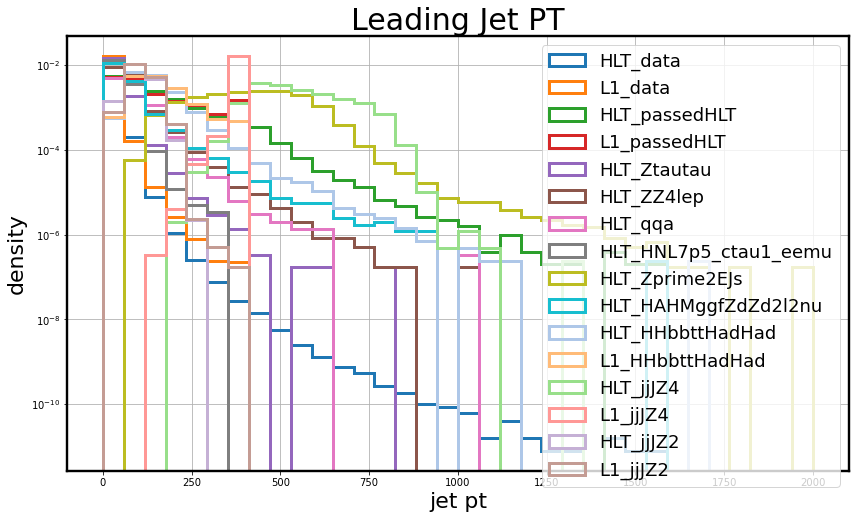

In [45]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for tag, data in datasets.items():
    pt = data[:, 0, 0]
    nonzero_pt = pt[pt > 0]

    nonzero_weights = (weights[tag])[pt > 0]
    plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [46]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, data in datasets.items():

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [47]:
"""Normalize pt """
for tag, data in datasets.items():
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [48]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (997315, 20, 3)
L1_data: (997315, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [49]:
# Flatten ndarrays for use in DNN

for tag, data in datasets.items():
    datasets[tag] = np.reshape(data, newshape=(-1, 60))

for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (997315, 60)
L1_data: (997315, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)


In [50]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [51]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [52]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

# HLT_tags = ['train', 'val', 'test_bkg', 'test2', 'zerobias', 'Ztautau', 'HHbbttHadHad', 'ZZ4lep', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']
# HLT_datasets = []
# HLT_weights = []

# L1_tags = ['train', 'val', 'test_bkg', 'test2', 'passed_HLT', 'passed_L1', 'passed_only_L1']
# L1_datasets = []
# L1_weights = []

random_seed = 0 # random seed for replication between notebooks

# HLT -----------------------------------
# Split indices
indices = np.arange(len(datasets['HLT_data']))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
datasets['HLT_train'] = datasets['HLT_data'][train_indices]
weights['HLT_train'] = weights['HLT_data'][train_indices]
datasets['L1_train'] = datasets['L1_data'][train_indices]
weights['L1_train'] = weights['L1_data'][train_indices]
pass_HLT['HLT_train'] = pass_HLT['HLT_data'][train_indices]
pass_HLT['L1_train'] = pass_HLT['L1_data'][train_indices]

# Val splits
datasets['HLT_val'] = datasets['HLT_data'][val_indices]
weights['HLT_val'] = weights['HLT_data'][val_indices]
datasets['L1_val'] = datasets['L1_data'][val_indices]
weights['L1_val'] = weights['L1_data'][val_indices]
pass_HLT['HLT_val'] = pass_HLT['HLT_data'][val_indices]
pass_HLT['L1_val'] = pass_HLT['L1_data'][val_indices]

# Test 1 splits
datasets['HLT_test1'] = datasets['HLT_data'][test_1_indices]
weights['HLT_test1'] = weights['HLT_data'][test_1_indices]
datasets['L1_test1'] = datasets['L1_data'][test_1_indices]
weights['L1_test1'] = weights['L1_data'][test_1_indices]
pass_HLT['HLT_test1'] = pass_HLT['HLT_data'][test_1_indices]
pass_HLT['L1_test1'] = pass_HLT['L1_data'][test_1_indices]

# Test_2 splits
datasets['HLT_test2'] = datasets['HLT_data'][test_2_indices]
weights['HLT_test2'] = weights['HLT_data'][test_2_indices]
datasets['L1_test2'] = datasets['L1_data'][test_2_indices]
weights['L1_test2'] = weights['L1_data'][test_2_indices]
pass_HLT['HLT_test2'] = pass_HLT['HLT_data'][test_2_indices]
pass_HLT['L1_test2'] = pass_HLT['L1_data'][test_2_indices]

# Remove old pre-split dataset
datasets.pop('HLT_data')
datasets.pop('L1_data')
weights.pop('HLT_data')
weights.pop('L1_data')
pass_HLT.pop('HLT_data')
pass_HLT.pop('L1_data')

# Printing
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)
HLT_train: (498657, 60)
L1_train: (498657, 60)
HLT_val: (99731, 60)
L1_val: (99731, 60)
HLT_test1: (199463, 60)
L1_test1: (199463, 60)
HLT_test2: (199464, 60)
L1_test2: (199464, 60)


In [20]:
# Initialize models
INPUT_DIM = datasets['HLT_train'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3

HLT_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
L1_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

2024-05-02 15:29:57.499373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 15:29:57.529444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 15:29:57.529793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 32)                1952      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
 dense_3 (Dense)             (None, 8)                 32        
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 60)                1980  

In [21]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [23]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4
MIN_LR = 0.00001
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1, min_lr=MIN_LR)

callbacks = [early_stopping, reduce_lr]

In [24]:
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [25]:
# train HLT model
history = HLT_AE.fit(x=datasets['HLT_train'], y=datasets['HLT_train'], validation_data=(datasets['HLT_val'], datasets['HLT_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['HLT_train'])

Epoch 1/150


2024-05-02 15:30:47.033853: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ddd9c5bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-02 15:30:47.033919: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-02 15:30:47.047852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 15:30:47.080993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-02 15:30:47.275341: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


974/974 [==============================] - 8s 5ms/step - loss: 94197.4375 - val_loss: 0.9474 - lr: 0.0010
Epoch 2/150
974/974 [==============================] - 4s 4ms/step - loss: 89461.2734 - val_loss: 0.9160 - lr: 0.0010
Epoch 3/150
974/974 [==============================] - 4s 4ms/step - loss: 87334.8906 - val_loss: 0.9034 - lr: 0.0010
Epoch 4/150
974/974 [==============================] - 4s 4ms/step - loss: 86403.7188 - val_loss: 0.8962 - lr: 0.0010
Epoch 5/150
974/974 [==============================] - 4s 4ms/step - loss: 85912.0312 - val_loss: 0.8914 - lr: 0.0010
Epoch 6/150
974/974 [==============================] - 4s 4ms/step - loss: 85287.1016 - val_loss: 0.8831 - lr: 0.0010
Epoch 7/150
974/974 [==============================] - 4s 4ms/step - loss: 84362.2266 - val_loss: 0.8731 - lr: 0.0010
Epoch 8/150
974/974 [==============================] - 4s 4ms/step - loss: 83548.8359 - val_loss: 0.8656 - lr: 0.0010
Epoch 9/150
974/974 [==============================] - 4s 4ms/step -

In [26]:
HLT_AE.save_weights('./trained_models/EB_HLT_zerobias.keras')

In [53]:
HLT_AE.load_weights('./trained_models/EB_HLT_zerobias.keras')

In [28]:
# train L1 model
history = L1_AE.fit(x=datasets['L1_train'], y=datasets['L1_train'], validation_data=(datasets['L1_val'], datasets['L1_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['L1_train'])

Epoch 1/150
974/974 [==============================] - 7s 5ms/step - loss: 39233.4375 - val_loss: 0.3669 - lr: 0.0010
Epoch 2/150
974/974 [==============================] - 4s 4ms/step - loss: 34661.9180 - val_loss: 0.3574 - lr: 0.0010
Epoch 3/150
974/974 [==============================] - 4s 4ms/step - loss: 33927.3750 - val_loss: 0.3508 - lr: 0.0010
Epoch 4/150
974/974 [==============================] - 4s 4ms/step - loss: 33343.1484 - val_loss: 0.3458 - lr: 0.0010
Epoch 5/150
974/974 [==============================] - 4s 4ms/step - loss: 32858.3984 - val_loss: 0.3412 - lr: 0.0010
Epoch 6/150
974/974 [==============================] - 4s 4ms/step - loss: 32484.4141 - val_loss: 0.3380 - lr: 0.0010
Epoch 7/150
974/974 [==============================] - 4s 4ms/step - loss: 32174.1426 - val_loss: 0.3353 - lr: 0.0010
Epoch 8/150
974/974 [==============================] - 4s 4ms/step - loss: 31925.6641 - val_loss: 0.3328 - lr: 0.0010
Epoch 9/150
974/974 [==============================] - 4

In [29]:
L1_AE.save_weights('./trained_models/EB_L1_zerobias.keras')

In [54]:
L1_AE.load_weights('./trained_models/EB_L1_zerobias.keras')

## Evaluate Model

In [55]:
# Pass the datasets through the model

skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val']
model_outputs = {}

for tag, data in datasets.items():
    if tag in skip_tags: continue # skip the train and val datasets

    if tag.startswith('HLT'):
        model_outputs[tag] = HLT_AE.predict(data)

    if tag.startswith('L1'):
        model_outputs[tag] = L1_AE.predict(data)

for key, value in model_outputs.items():
    print(f'{key}: {value.shape}')

6234/6234 [==============================] - 10s 2ms/step
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)
HLT_test1: (199463, 60)
L1_test1: (199463, 60)
HLT_test2: (199464, 60)
L1_test2: (199464, 60)


In [56]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [57]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [58]:
# Calculate the AD scores

AD_scores = {}

for tag, model_output in model_outputs.items():
    AD_scores[tag] = AD_score(datasets[tag], model_output)

for key, value in AD_scores.items():
    print(f'{key}: {value.shape}')

HLT_passedHLT: (7850,)
L1_passedHLT: (7850,)
HLT_Ztautau: (100000,)
HLT_ZZ4lep: (100000,)
HLT_qqa: (50000,)
HLT_HNL7p5_ctau1_eemu: (10000,)
HLT_Zprime2EJs: (100000,)
HLT_HAHMggfZdZd2l2nu: (70000,)
HLT_HHbbttHadHad: (70000,)
L1_HHbbttHadHad: (100000,)
HLT_jjJZ4: (70000,)
L1_jjJZ4: (100000,)
HLT_jjJZ2: (70000,)
L1_jjJZ2: (100000,)
HLT_test1: (199463,)
L1_test1: (199463,)
HLT_test2: (199464,)
L1_test2: (199464,)


<Figure size 1296x720 with 0 Axes>

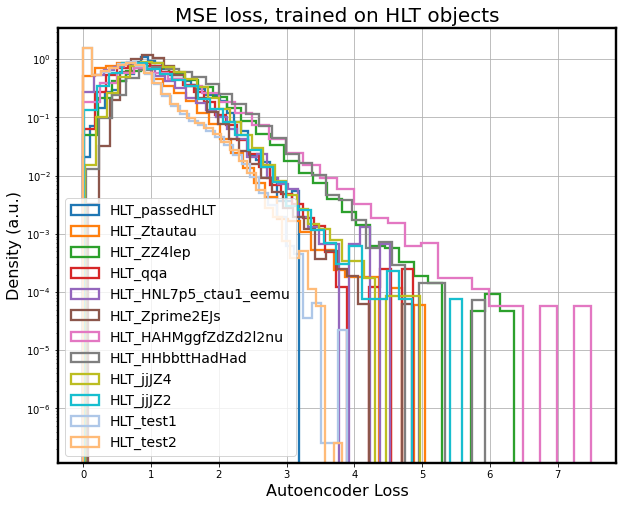

In [59]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, data in AD_scores.items():
    if tag.startswith('HLT'):
        plt.hist(data, bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights[tag])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on HLT objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1296x720 with 0 Axes>

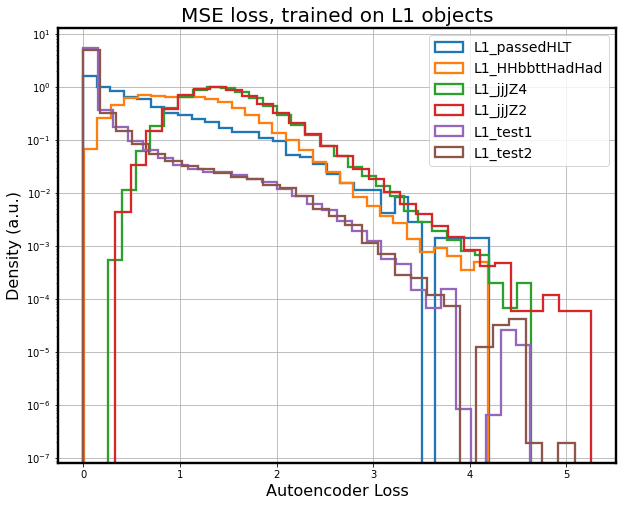

In [60]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, data in AD_scores.items():
    if tag.startswith('L1'):
        plt.hist(data, bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights[tag])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on L1 objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

HLT_passedHLT: TPR at FPR of 10^-4 is 0.00059 with threshold 3.0470
HLT_Ztautau: TPR at FPR of 10^-4 is 0.00075 with threshold 3.0470
HLT_ZZ4lep: TPR at FPR of 10^-4 is 0.00831 with threshold 3.0470
HLT_qqa: TPR at FPR of 10^-4 is 0.00142 with threshold 3.0470
HLT_HNL7p5_ctau1_eemu: TPR at FPR of 10^-4 is 0.00190 with threshold 3.0470
HLT_Zprime2EJs: TPR at FPR of 10^-4 is 0.00085 with threshold 3.0470
HLT_HAHMggfZdZd2l2nu: TPR at FPR of 10^-4 is 0.01430 with threshold 3.0470
HLT_HHbbttHadHad: TPR at FPR of 10^-4 is 0.01039 with threshold 3.0470
HLT_jjJZ4: TPR at FPR of 10^-4 is 0.00161 with threshold 3.0470
HLT_jjJZ2: TPR at FPR of 10^-4 is 0.00136 with threshold 3.0470
HLT_test2: TPR at FPR of 10^-4 is 0.00014 with threshold 3.0470


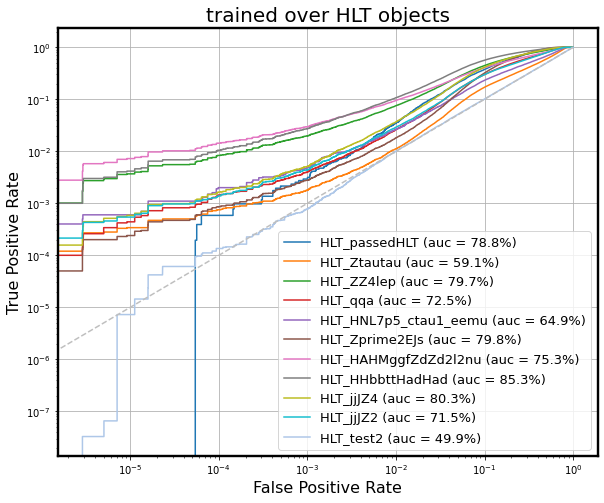

In [61]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['HLT_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

FPR = {}
TPR = {}
thresholds = {}

for tag in AD_scores.keys():
    if tag.startswith('HLT') and tag != 'HLT_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['HLT_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['HLT_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'HLT_test2': 
            HLT_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
        
        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over HLT objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

L1_passedHLT: TPR at FPR of 10^-4 is 0.00157 with threshold 3.3093
L1_HHbbttHadHad: TPR at FPR of 10^-4 is 0.00076 with threshold 3.3093
L1_jjJZ4: TPR at FPR of 10^-4 is 0.00191 with threshold 3.3093
L1_jjJZ2: TPR at FPR of 10^-4 is 0.00243 with threshold 3.3093
L1_test2: TPR at FPR of 10^-4 is 0.00012 with threshold 3.3093


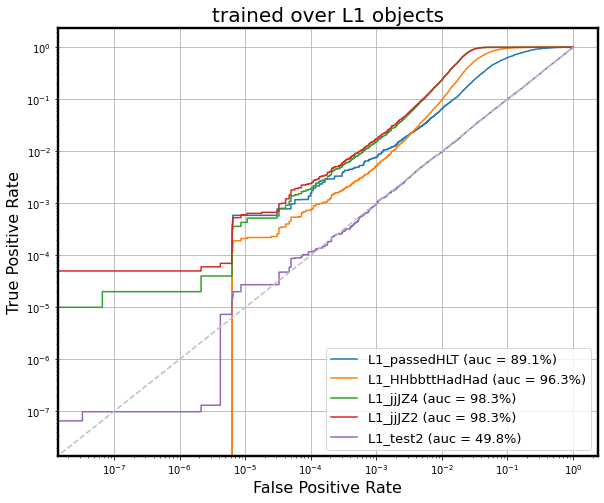

In [62]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['L1_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

for tag in AD_scores.keys():
    if tag.startswith('L1') and tag != 'L1_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['L1_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['L1_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'L1_test2': 
            L1_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value

        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")


# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over L1 objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [63]:
HLT_diff = datasets['HLT_test1'] - model_outputs['HLT_test1']
L1_diff = datasets['L1_test1'] - model_outputs['L1_test1']

HLT_mean = np.mean(np.abs(HLT_diff), axis=0).reshape(20, 3)
HLT_std = np.std(np.abs(HLT_diff), axis=0).reshape(20, 3)
L1_mean = np.mean(np.abs(L1_diff), axis=0).reshape(20, 3)
L1_std = np.std(np.abs(L1_diff), axis=0).reshape(20, 3)

print("abs(HLT event - reconstruction)")
for i in range(20):
    print(f'{HLT_mean[i, 0]:.3f} +- {HLT_std[i, 0]:.3f}     {HLT_mean[i, 1]:.3f} +- {HLT_std[i, 1]:.3f}     {HLT_mean[i, 2]:.3f} +- {HLT_std[i, 2]:.3f}')

print("abs(L1 event - reconstruction)")
for i in range(20):
    print(f'{L1_mean[i, 0]:.3f} +- {L1_std[i, 0]:.3f}     {L1_mean[i, 1]:.3f} +- {L1_std[i, 1]:.3f}     {L1_mean[i, 2]:.3f} +- {L1_std[i, 2]:.3f}')

abs(HLT event - reconstruction)
0.081 +- 0.092     1.177 +- 0.978     1.089 +- 0.804
0.053 +- 0.053     0.758 +- 1.011     1.338 +- 0.999
0.039 +- 0.041     1.139 +- 0.866     1.344 +- 0.993
0.034 +- 0.035     1.089 +- 1.383     1.323 +- 0.992
0.031 +- 0.030     1.412 +- 1.146     1.277 +- 1.005
0.029 +- 0.027     1.283 +- 1.180     1.222 +- 1.021
0.028 +- 0.024     1.143 +- 1.133     1.163 +- 1.031
0.027 +- 0.022     1.065 +- 1.117     1.101 +- 1.027
0.027 +- 0.020     0.940 +- 1.090     1.050 +- 1.005
0.026 +- 0.019     0.880 +- 1.043     0.965 +- 1.010
0.102 +- 0.013     1.143 +- 0.420     1.083 +- 0.637
0.016 +- 0.010     1.072 +- 0.523     0.955 +- 0.609
0.055 +- 0.049     1.690 +- 1.072     1.090 +- 0.984
0.060 +- 0.015     0.382 +- 0.299     0.185 +- 0.397
0.034 +- 0.006     0.270 +- 0.203     0.229 +- 0.171
0.031 +- 0.009     0.337 +- 0.245     0.290 +- 0.219
0.038 +- 0.038     0.711 +- 0.580     1.015 +- 0.686
0.039 +- 0.023     0.682 +- 0.549     1.008 +- 0.653
0.024 +- 0.014

In [31]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('HLT') and tag != 'HLT_passedHLT':
        anomaly_idxs = data > HLT_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
HLT_zerobias:
HLT overlap: 0.00014975945199250689
inverse overlap: 7.728444572115307
percentage of events that passed some HLT trigger: 0.0010400489555800105
percentage of events that we tagged as anomalous: 5.913751786981518e-05
number of events that we tagged as anomalous: 46
-----
HLT_Ztautau:
HLT overlap: 0.14043583535108958
inverse overlap: 1.0533273246207
percentage of events that passed some HLT trigger: 0.06657
percentage of events that we tagged as anomalous: 0.00413
number of events that we tagged as anomalous: 413
-----
HLT_ZZ4lep:
HLT overlap: 0.9362206689965052
inverse overlap: 1.0058614361091993
percentage of events that passed some HLT trigger: 0.8718
percentage of events that we tagged as anomalous: 0.08012
number of events that we tagged as anomalous: 8012
-----
HLT_qqa:
HLT overlap: 0.1518987341772152
inverse overlap: 1.1038299756475536
percentage of events that passed some HLT trigger: 0.09034
percentage of events that 

In [32]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('L1') and tag not in ['L1_passedHLT', 'L1_zerobias']:
        anomaly_idxs = data > L1_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
L1_HHbbttHadHad:
HLT overlap: 1.0
inverse overlap: 1.0
percentage of events that passed some HLT trigger: 0.5459
percentage of events that we tagged as anomalous: 3e-05
number of events that we tagged as anomalous: 3
-----
L1_jjJZ4:
HLT overlap: 0.9285714285714286
inverse overlap: 1.0000101874490628
percentage of events that passed some HLT trigger: 0.9816
percentage of events that we tagged as anomalous: 0.00014
number of events that we tagged as anomalous: 14
-----
L1_jjJZ2:
HLT overlap: 0.0
inverse overlap: 1.0074766355140188
percentage of events that passed some HLT trigger: 0.0107
percentage of events that we tagged as anomalous: 8e-05
number of events that we tagged as anomalous: 8
-----
L1_test1:
HLT overlap: 0.0
inverse overlap: 1.0048423773076038
percentage of events that passed some HLT trigger: 0.032077277076593615
percentage of events that we tagged as anomalous: 9.112862805850458e-05
number of events that we tagged as anomalou

In [33]:
threshold = HLT_threshold

anomaly_idxs = (AD_scores['HLT_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
# HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)
print(f'additional rate at 10e-4: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

additional rate at 10e-4: 10.050219915943432


In [48]:
HLT_rates = []
for i, fpr in enumerate(FPR['HLT_test2']):
    threshold = thresholds['HLT_test2'][i]
    
    anomaly_idxs = (AD_scores['HLT_test2'] > threshold) 
    HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
    HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['HLT_test2'])}")

progress: 1 / 56819
progress: 10001 / 56819
progress: 20001 / 56819
progress: 30001 / 56819
progress: 40001 / 56819
progress: 50001 / 56819


In [49]:
L1_rates = []
for i, fpr in enumerate(FPR['L1_test2']):
    threshold = thresholds['L1_test2'][i]

    anomaly_idxs = (AD_scores['L1_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights['L1_test2'] * pass_HLT['L1_test2']) / np.sum(weights['L1_test2'])
    HLT_AD_acceptance = np.sum(weights['L1_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['L1_test2'])) / np.sum(weights['L1_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['L1_test2'])}")

progress: 1 / 56868
progress: 10001 / 56868
progress: 20001 / 56868
progress: 30001 / 56868
progress: 40001 / 56868
progress: 50001 / 56868


In [50]:
print(len(FPR['HLT_test2']))
      
print(len(HLT_rates))

56819
56819


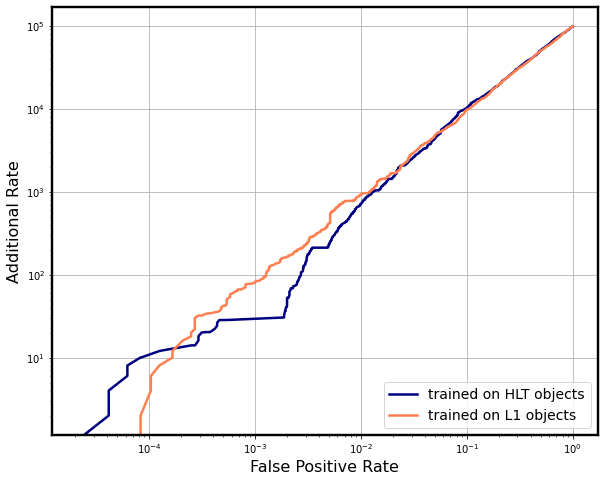

In [51]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(FPR['HLT_test2'], HLT_rates, color='navy', linewidth=2.5, label='trained on HLT objects')
plt.plot(FPR['L1_test2'], L1_rates, color='coral', linewidth=2.5, label='trained on L1 objects')

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

#plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

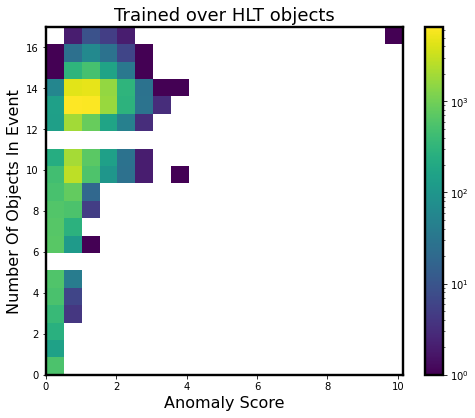

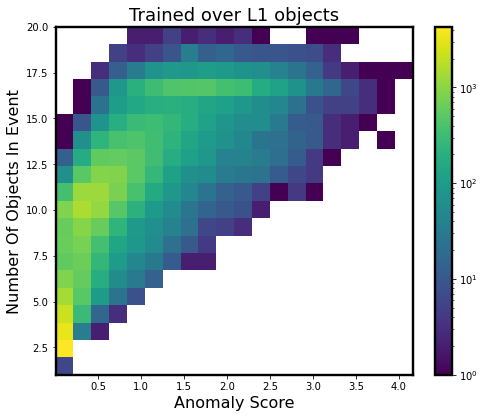

In [56]:
# Make a histogram of multiplicity vs anomaly score

HLT_pt_values = datasets['HLT_test2'].reshape(-1, 20, 3)[:, :, 0]
L1_pt_values = datasets['L1_test2'].reshape(-1, 20, 3)[:, :, 0]
HLT_num_objects = np.count_nonzero(HLT_pt_values, axis=1)
L1_num_objects = np.count_nonzero(L1_pt_values, axis=1)

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['HLT_test2'], HLT_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over HLT objects', fontsize=18)
plt.show()

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['L1_test2'], L1_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over L1 objects', fontsize=18)
plt.show()

In [39]:
# now I need to figure out, at some specific FPR, the overlap between HLT and the L1

In [40]:
HLT_anomaly_idxs = HLT_AD_scores[1] > HLT_threshold
L1_anomaly_idxs = L1_AD_scores[1] > L1_threshold

num_overlaps = np.sum(np.bitwise_and(HLT_anomaly_idxs, L1_anomaly_idxs))
num_HLT_anomalies = np.sum(HLT_anomaly_idxs)
num_L1_anomalies = np.sum(L1_anomaly_idxs)

# Calculate the fractions
f_HLT = (num_overlaps / num_HLT_anomalies)
f_L1 = (num_overlaps / num_L1_anomalies)

print(f'number of events that both the HLT and L1 models flagged as anomalous: {num_overlaps}')
print(f'out of the HLT anomalies, what fraction are also L1 anomalies? {f_HLT}')
print(f'out of the L1 anomalies, what fraction are also HLT anomalies? {f_L1}')

number of events that both the HLT and L1 models flagged as anomalous: 0
out of the HLT anomalies, what fraction are also L1 anomalies? 0.0
out of the L1 anomalies, what fraction are also HLT anomalies? 0.0


In [41]:
print(f'number of L1 anomalies: {num_L1_anomalies}')
print(f'number of HLT anomalies: {num_HLT_anomalies}')

number of L1 anomalies: 7
number of HLT anomalies: 8


In [76]:
# Let's take a closer look at these anomalies
HLT_anomalies = HLT_y_true[1][HLT_anomaly_idxs]
HLT_anom_outputs = HLT_model_outputs[1][HLT_anomaly_idxs]
L1_anomalies = L1_y_true[1][L1_anomaly_idxs]
L1_anom_outputs = L1_model_outputs[1][L1_anomaly_idxs]

print(f'Anomalies found by model trained on HLT objects:')
for i in range(len(HLT_anomalies)):
    print(f'event:\n{HLT_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{HLT_anom_outputs[i].reshape(-1, 20, 3)}')

print(f'Anomalies found by model trained on L1 objects:')
for i in range(len(L1_anomalies)):
    print(f'event:\n{L1_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{L1_anom_outputs[i].reshape(-1, 20, 3)}')

Anomalies found by model trained on HLT objects:
event:
[[[ 0.18945431  0.4822886  -0.30662119]
  [ 0.14006709  0.0747449   2.48758316]
  [ 0.10698286 -4.40890455  2.29233575]
  [ 0.10339661 -3.51014018 -0.84333491]
  [ 0.08084805  4.40199375 -2.6154201 ]
  [ 0.05505495  3.06775713 -2.3277216 ]
  [ 0.05356225  4.37638283  0.78126425]
  [ 0.04481367 -2.55221438 -0.62268186]
  [ 0.04245868  1.20024025  2.29764962]
  [ 0.03930756  2.72266507  3.05115509]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.01930252  0.49109831 -0.34072194]
  [ 0.          0.          0.        ]]]
reconstruction:
[[[ 0.07721651 -2.3509588   0.15923315]
  [ 0.09922105 -1.2720616   3.5524993 ]
  [ 0.08455377 -3.1708102  -0.55961454]
  [ 0.

In [42]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for i, tag in enumerate(HLT_tags):
    anomaly_idxs = HLT_AD_scores[i] > HLT_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
data (background):
HLT overlap: 0.0
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 9.052845988457622e-05
number of events that we tagged as anomalous: 4
-----
HLT:
HLT overlap: 0.0
inverse overlap: 1.0056100981767182
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.00018323827847637373
number of events that we tagged as anomalous: 8
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0469798657718121
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 4.492795481531401e-05
number of events that we tagged as anomalous: 7
-----
HHbbttHadHad:
HLT overlap: 0.5757575757575758
inverse overlap: 1.0038627793617216
percentage of events that passed some HLT trigger: 0.54365
percentage of events tha

In [43]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for i, tag in enumerate(L1_tags):
    anomaly_idxs = L1_AD_scores[i] > L1_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
data (background):
HLT overlap: 0.2
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 0.00011316057485572027
number of events that we tagged as anomalous: 5
-----
L1 objects:
HLT overlap: 0.0
inverse overlap: 1.0049088359046283
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.000160333493666827
number of events that we tagged as anomalous: 7
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0268456375838926
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 2.5673117037322294e-05
number of events that we tagged as anomalous: 4


In [65]:
HLT_rates = []
HLT_num_objects = []
for i, fpr in enumerate(HLT_fpr_loss):
    threshold = HLT_threshold_loss[i]

    anomaly_idxs = (HLT_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = HLT_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    #HLT_num_objects.append(np.average(num_objects_per_event, weights=anom_weights))
    HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(HLT_fpr_loss)}')

/tmp/ipykernel_372/3218523813.py:15: RuntimeWarning: invalid value encountered in double_scalars
  HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))


progress: 1 / 57940
progress: 10001 / 57940
progress: 20001 / 57940
progress: 30001 / 57940
progress: 40001 / 57940
progress: 50001 / 57940


In [66]:
L1_rates = []
L1_num_objects = []
for i, fpr in enumerate(L1_fpr_loss):
    threshold = L1_threshold_loss[i]

    anomaly_idxs = (L1_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = L1_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    L1_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(L1_fpr_loss)}')

progress: 1 / 127979
progress: 10001 / 127979
progress: 20001 / 127979
progress: 30001 / 127979
progress: 40001 / 127979
progress: 50001 / 127979
progress: 60001 / 127979
progress: 70001 / 127979
progress: 80001 / 127979
progress: 90001 / 127979
progress: 100001 / 127979
progress: 110001 / 127979
progress: 120001 / 127979


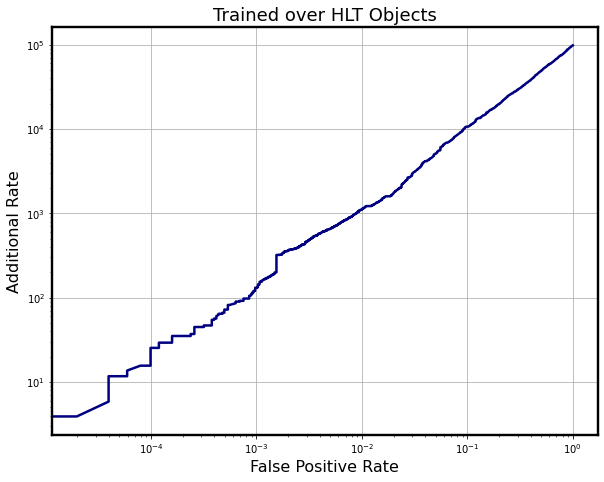

In [67]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

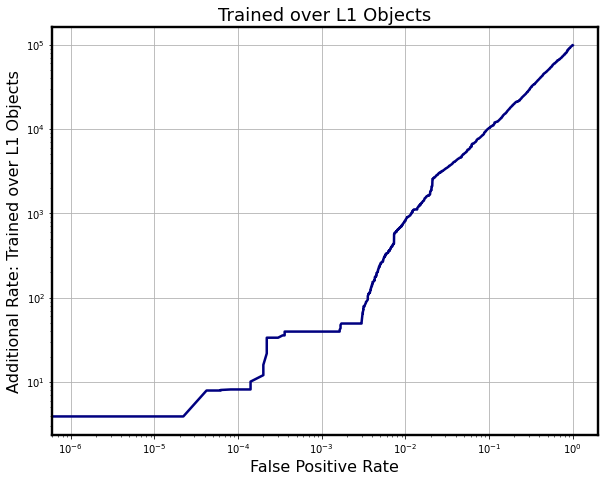

In [68]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("Additional Rate: Trained over L1 Objects", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [69]:
target_fpr = 10**-4
HLT_idx = np.argmin(np.abs(HLT_fpr_loss - target_fpr))
L1_idx = np.argmin(np.abs(L1_fpr_loss - target_fpr))

print(f'Pure rate at fpr=10e-4: {HLT_rates[HLT_idx]} (trained over HLT objects)')
print(f'Pure rate at fpr=10e-4: {L1_rates[L1_idx]} (trained over L1 objects)')

Pure rate at fpr=10e-4: 15.612964742042074 (trained over HLT objects)
Pure rate at fpr=10e-4: 8.156675357946785 (trained over L1 objects)


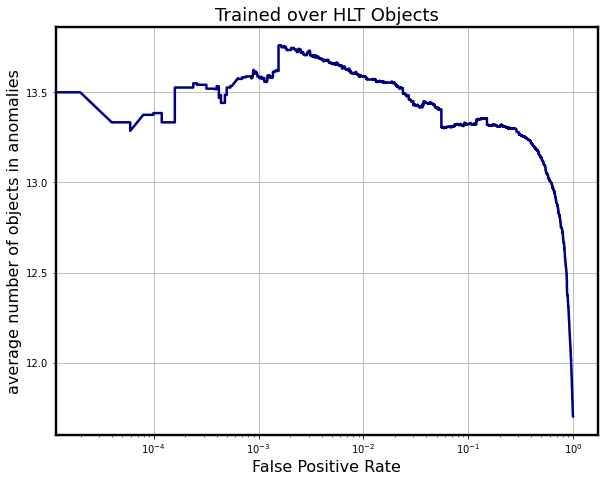

In [72]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

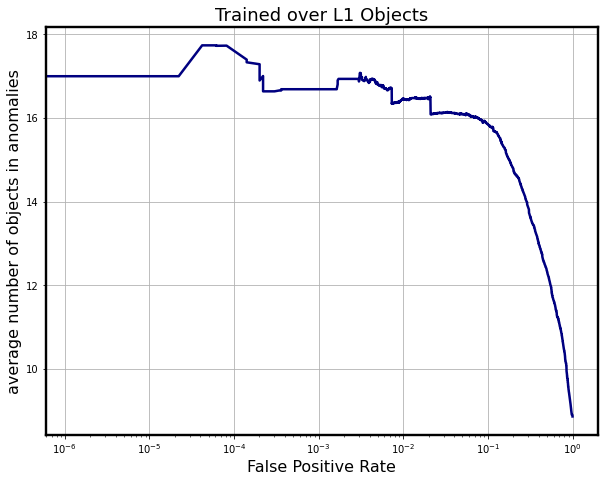

In [73]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [74]:
pt_values = HLT_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
HLT_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with HLT objects: {HLT_num_objs}')

average number of objects per event in the whole test data with HLT objects: 11.692775578449224


In [75]:
pt_values = L1_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
L1_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with L1 objects: {L1_num_objs}')

average number of objects per event in the whole test data with L1 objects: 8.855968094629004
